IMPORTING MODULES

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import os
import numpy as np

LOADING DATA

In [11]:
BATCH_SIZE = 128
IMAGE_SIZE = 75

In [16]:
df = tf.keras.preprocessing.image_dataset_from_directory('../dataset/seg_train', shuffle=True, image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, label_mode='categorical') 

Found 17034 files belonging to 6 classes.


In [17]:
class_names = df.class_names
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

DATA SPLIT AND TF PIPELINE

In [9]:
def validation_partition(df, train_split=0.8, val_split=0.1, shuffle=True, shuffle_size = 100):
    df_size = len(df)
    if shuffle:
        df = df.shuffle(shuffle_size, seed=42)
    
    train_size = int(df_size*train_split)
    val_size = int(df_size*val_split)
    
    
    train_df = df.take(train_size)
    val_df = df.skip(train_size).take(val_size)
    test_df = df.skip(train_size+val_size)
    return train_df, test_df, val_df

train_df, test_df, val_df = validation_partition(df, train_split=0.8, val_split=0.1, shuffle=True, shuffle_size=100)

def make_pipe(DATA, RATE):
    return DATA.cache().shuffle(RATE).prefetch(tf.data.AUTOTUNE)

train_df = make_pipe(train_df, 1000)
test_df = make_pipe(test_df, 1000)
val_df = make_pipe(val_df, 1000)

In [10]:
len(train_df), len(val_df), len(test_df)

(107, 13, 14)

IMAGE PREPROCESSING LAYER

In [12]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

TRANSFER LEARNING

In [12]:
vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
vgg16.trainable = False
vgg19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
vgg19.trainable = False
resnet = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
resnet.trainable = False
inception = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
inception.trainable = False
mobilenet = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
mobilenet.trainable = False
efficientnet = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
efficientnet.trainable = False


MODEL BUILDING

In [13]:
LEARNING_RATE = 0.001
THRESHOLD = 0.5
METRICS = [
    'accuracy',
    tf.keras.metrics.AUC(num_thresholds=100, thresholds=[THRESHOLD]),
    tf.keras.metrics.Precision(thresholds=THRESHOLD),
    tf.keras.metrics.Recall(thresholds=THRESHOLD)
]
METRICS_LIST = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
EPOCHS = 5

In [14]:
def create_model(LEARNING_RATE, METRICS, TRANSFER_LAYER):
    model = tf.keras.models.Sequential([
        resize_and_rescale,
        TRANSFER_LAYER,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    
    model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, 3))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics = METRICS)
    return model

my_model = create_model(LEARNING_RATE, METRICS, inception)

In [15]:
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 75, 75, 3)         0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 6)                 6150      
                                                                 
Total params: 23907110 (91.20 MB)
Trainable params: 2104326 (8.03 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


MODEL TRAINING

In [16]:
def train_model(MODEL, TRAIN_DATA, EPOCHS, BATCH_SIZE, VAL_DATA):
    history = MODEL.fit(TRAIN_DATA, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=VAL_DATA)
    return history

history = train_model(MODEL=my_model, TRAIN_DATA=train_df, EPOCHS=EPOCHS, BATCH_SIZE=BATCH_SIZE, VAL_DATA=val_df)

Epoch 1/5
107/107 [==============================] - 33s 266ms/step - loss: 0.7776 - accuracy: 0.7177 - auc: 0.8032 - precision: 0.7867 - recall: 0.6411 - val_loss: 0.5147 - val_accuracy: 0.8119 - val_auc: 0.8707 - val_precision: 0.8631 - val_recall: 0.7656
Epoch 2/5
107/107 [==============================] - 25s 232ms/step - loss: 0.4666 - accuracy: 0.8299 - auc: 0.8813 - precision: 0.8669 - recall: 0.7868 - val_loss: 0.4042 - val_accuracy: 0.8504 - val_auc: 0.8999 - val_precision: 0.8887 - val_recall: 0.8203
Epoch 3/5
107/107 [==============================] - 27s 253ms/step - loss: 0.3380 - accuracy: 0.8788 - auc: 0.9161 - precision: 0.9063 - recall: 0.8498 - val_loss: 0.3286 - val_accuracy: 0.8966 - val_auc: 0.9274 - val_precision: 0.9131 - val_recall: 0.8714
Epoch 4/5
107/107 [==============================] - 27s 255ms/step - loss: 0.2253 - accuracy: 0.9265 - auc: 0.9497 - precision: 0.9421 - recall: 0.9106 - val_loss: 0.2482 - val_accuracy: 0.9345 - val_auc: 0.9541 - val_precisi

In [17]:
score = my_model.evaluate(test_df)

14/14 [==============================] - 6s 226ms/step - loss: 0.2064 - accuracy: 0.9420 - auc: 0.9623 - precision: 0.9490 - recall: 0.9347


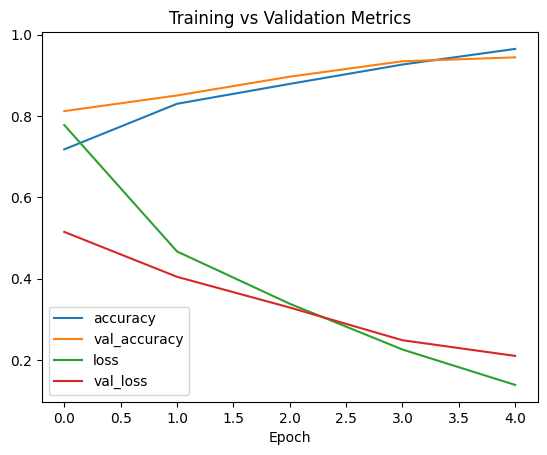

In [18]:
def plot_metrics(HISTORY, METRICS_LIST):
    for m in METRICS_LIST:
        plt.plot(HISTORY.epoch, HISTORY.history[m], label=m)
    plt.legend()
    plt.xlabel('Epoch')
    plt.title('Training vs Validation Metrics')
    plt.ylim()

plot_metrics(history, METRICS_LIST)

TESTING PREDICTION ON UNSEEN DATA

In [22]:
pred_df = tf.keras.preprocessing.image_dataset_from_directory('/Users/alex/Desktop/projects/ImageClassifier/dataset/single_image', label_mode=None, image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE)

Found 1 files belonging to 1 classes.


In [23]:
def image_predict(model, class_names, prediction_df):
    for image_batch in prediction_df.take(1):
        img = image_batch[0].numpy().astype('uint8') #astype('uint8') - for showing the image
        plt.imshow(img)
        img = resize_and_rescale(img)
        batched_pred = model.predict(image_batch)
        result = class_names[np.argmax(batched_pred[0])]
        confidence = round(100*(np.max(batched_pred[0])), 2)
    return print('Model prediction: ',result, ' Confidence:', f"{confidence}%")

1/1 [==============================] - 0s 20ms/step
Model prediction:  sea  Confidence: 93.48%


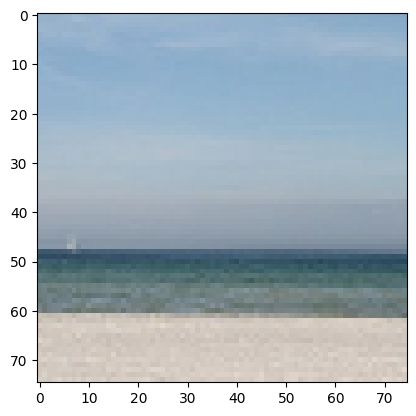

In [24]:
image_predict(my_model, class_names, pred_df)

MODEL SAVING

In [20]:
def save_model(FOLDER_PATH, MODEL):
    def find_index(FOLDER_PATH):
        index = 0
        while os.path.exists(os.path.join(FOLDER_PATH,f'model_{index}.keras')):
            index += 1
        return index
    index = find_index(FOLDER_PATH)
    MODEL.save(os.path.join(FOLDER_PATH, f'model_{index}.keras'))

save_model('../models/',my_model)